# 3-2. kmeans clustering with Pearson correlation
Baseline models. Statistical properties of cluters are shown. Representative time series of each clusters are obtained in order to compare results of effienct frontiers.

OUTPUT PATH: rts

In [ ]:
!pip3 install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 7.8 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=f009fce7123456bbc647444c1b9ab366a440197afc8d31f7cb5908d4072261da
  Stored in directory: /root/.cache/pip/wheels/dc/25/8b/072b221a5cff4f04e7999d39ca1b6cb5dad702cc3e1da951d4
Successfully built pyclustering


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

SEED = 0

In [ ]:
# filtered log return data for making cumulative filtered log return
df_lr_f = pd.read_csv("data/coin_log_return_filtered.csv")
df_cum_f = df_lr_f.cumsum(axis=0) # cumulative filtered log return data

# price data
price_data = pd.read_csv(f"data/coingecko_usd_price.csv").drop(columns=["uts"])
price_data = price_data.T

# log return data
lr_data = pd.read_csv(f"data/coin_log_return.csv")
lr_data = lr_data.T
lr_data = lr_data.drop(columns=[0]) # drop zero return

In [ ]:
# Pearson coefficient
from scipy import stats
def pearson_dist(x, y):
    r = stats.pearsonr(x, y)[0]
    return (1 - r) / 2

In [ ]:
# Filtered cumulative log return
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette

# change your df to numpy arr
sample = df_cum_f.T.to_numpy()
sample
# # define a custom metric
metric = distance_metric(type_metric.USER_DEFINED, func=pearson_dist)
# carry out a km++ init
initial_centers = kmeans_plusplus_initializer(sample, 4, random_state=SEED).initialize()
# execute kmeans
kmeans_instance = kmeans(sample, initial_centers, metric=metric)
# run cluster analysis
kmeans_instance.process()
# get clusts
clusters = kmeans_instance.get_clusters()

# Calculate Silhouette score
score = silhouette(sample, clusters).process().get_score()
print(f"{4}-division:{np.mean(score)}")

df_transpose= df_cum_f.T

for i in range(len(clusters)):
    df_transpose.loc[df_transpose.index[clusters[i]], 'cluster'] = i

4-division:0.14147921917339354


In [ ]:
labels = df_transpose["cluster"].to_numpy()

In [ ]:
# statistics dataframe
df_stat_R, df_stat_lr, annl_R, annl_lr, annl_lr_std, MDD = get_stats(labels, price_data, lr_data)

# clusters' statistics
df_ranked_stat_lr = rank_matching(df_stat_lr)
df_ranked_stat_lr

,cluster,log_return_mean[%],log_return_mean_std[%],log_return_median[%],log_return_std[%],log_return_std_std[%],skewness,kurtosis,mdd_mean[%],mdd_median[%],num_coins,common_cluster_label
3,3.0,279.404375,157.140187,268.654016,149.403291,60.051779,0.081561,-0.909141,62.870155,70.817215,32,A
2,2.0,225.285754,97.130655,201.492771,165.779826,31.768745,1.218493,1.536754,72.667856,72.130491,39,B
1,1.0,209.693273,56.024262,212.076377,170.743773,26.861343,0.635165,0.520339,75.319747,77.201085,13,C
0,0.0,51.731542,50.677992,48.439513,114.401424,53.807938,0.313083,-0.641106,60.684333,74.184241,62,D


In [ ]:
df_ranked_stat_lr.to_csv("kmeans_stats_label.csv")

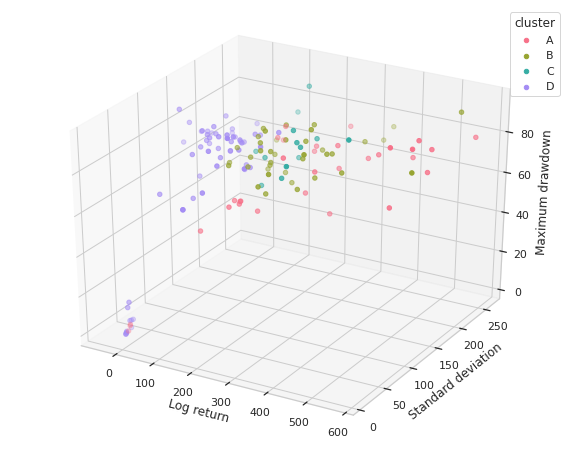

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

df = df_dist_plot.copy()

sns.set(style = "whitegrid")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection = '3d')

x_a = df[df["common_cluster_label"]=="A"]["crypto_annualised_log_return[%]"]
y_a = df[df["common_cluster_label"]=="A"]["crypto_annualised_std[%]"]
z_a = df[df["common_cluster_label"]=="A"]["crypto_mdd[%]"]

x_b = df[df["common_cluster_label"]=="B"]["crypto_annualised_log_return[%]"]
y_b = df[df["common_cluster_label"]=="B"]["crypto_annualised_std[%]"]
z_b = df[df["common_cluster_label"]=="B"]["crypto_mdd[%]"]

x_c = df[df["common_cluster_label"]=="C"]["crypto_annualised_log_return[%]"]
y_c = df[df["common_cluster_label"]=="C"]["crypto_annualised_std[%]"]
z_c = df[df["common_cluster_label"]=="C"]["crypto_mdd[%]"]

x_d = df[df["common_cluster_label"]=="D"]["crypto_annualised_log_return[%]"]
y_d = df[df["common_cluster_label"]=="D"]["crypto_annualised_std[%]"]
z_d = df[df["common_cluster_label"]=="D"]["crypto_mdd[%]"]

# define and map colors
colors = sns.color_palette("husl",4).as_hex()

ax.set_xlabel("Log return")
ax.set_ylabel("Standard deviation")
ax.set_zlabel("Maximum drawdown")

s_a = ax.scatter(x_a, y_a, z_a, c=colors[0], label="A")
s_b = ax.scatter(x_b, y_b, z_b, c=colors[1], label="B")
s_c = ax.scatter(x_c, y_c, z_c, c=colors[2], label="C")
s_d = ax.scatter(x_d, y_d, z_d, c=colors[3], label="D")

# produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="cluster")
# ax.add_artist(legend1)
ax.legend(title="cluster")

plt.show()

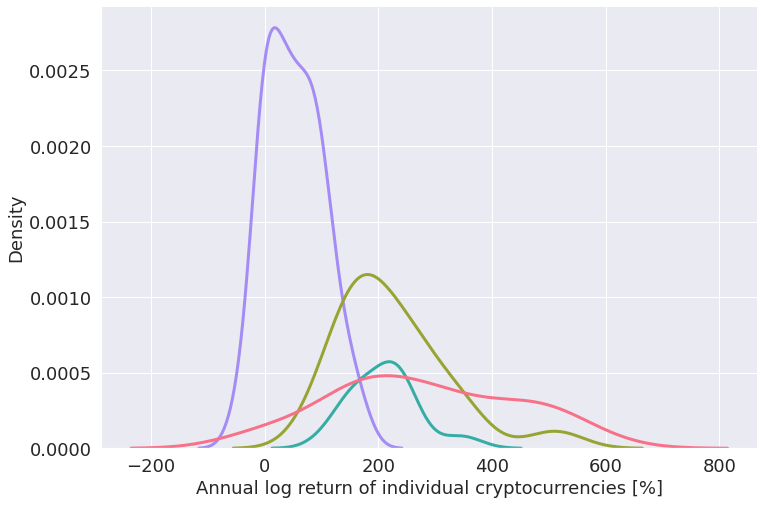

In [ ]:
# clusters' annaulized log return distribution
df_dist_plot = get_dist_plot(df_ranked_stat_lr, annl_lr, annl_lr_std, MDD)
plot_annlr(df_dist_plot)

[Text(0, 0.5, 'cluster'), Text(0.5, 0, 'maximum drawdown [%]')]

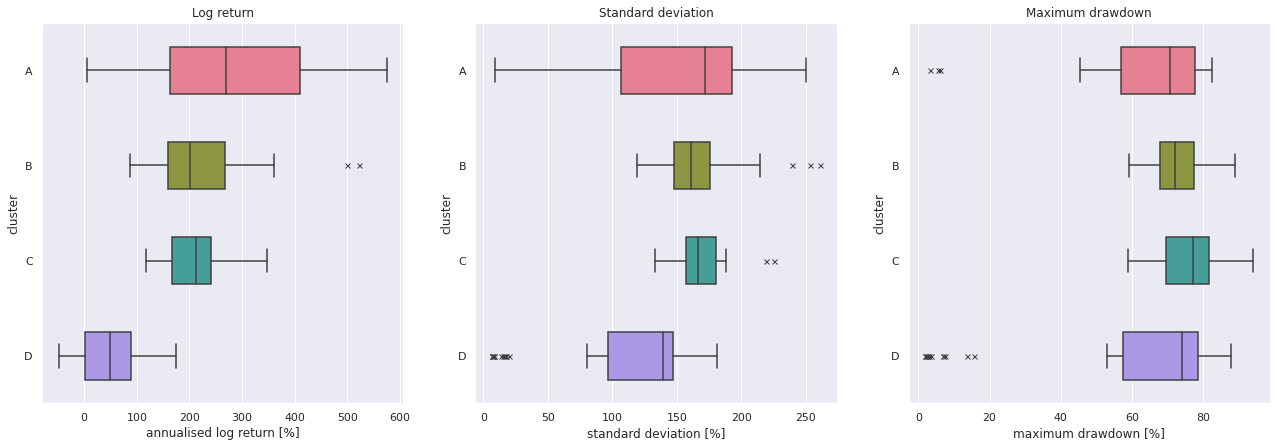

In [ ]:
# clusters' boxplot
plot_boxplot(df_dist_plot)

In [ ]:
labels = df_transpose["cluster"].to_numpy()
labels

array([0., 0., 3., 0., 0., 2., 3., 0., 2., 2., 3., 2., 0., 2., 0., 2., 1.,
       0., 3., 0., 0., 2., 1., 2., 0., 3., 1., 0., 0., 0., 0., 0., 3., 3.,
       1., 2., 0., 0., 1., 0., 0., 0., 2., 3., 2., 3., 2., 1., 2., 3., 2.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 2., 3., 3., 3., 0., 3., 1.,
       0., 0., 0., 0., 2., 0., 3., 2., 3., 3., 2., 0., 3., 3., 3., 3., 2.,
       3., 0., 2., 0., 0., 0., 2., 0., 2., 0., 1., 0., 1., 0., 0., 0., 2.,
       2., 2., 0., 0., 2., 0., 1., 3., 0., 2., 0., 0., 3., 0., 0., 0., 3.,
       2., 0., 2., 2., 2., 2., 0., 3., 3., 2., 3., 0., 1., 0., 1., 3., 3.,
       0., 2., 2., 2., 0., 0., 3., 1., 3., 2.])

In [ ]:
# clusters' representative time series
df_ts = get_rep_ts(labels)

In [ ]:
df_ts.to_csv(f"rts/kmeans_pearson_corr_weighted_average_time_series.csv", index=False)